In [9]:
# Preamble
import numpy as np
import pickle
import time

# Import multistateRC package
from multistateRC import *

# Visualization
import matplotlib.pyplot as plt

Navigation: <a id='top' />

<a href=#rc>RC classifier</a> 

### RC classifier <a id='rc' />

<a href=#top>Return to top</a>

Datasets provided have been divided into experimental datasets (E) and simulated datasets (S). These were used in arXiv: XYZ, and are indexed below:

Experimental (E) dataset:

- Type 3: Low T1 qubit as a function of measurement power 
- Type 5: High T1 qubit at fixed measurement power as a function of quantum amplifier pump phase 
- Type 7: Moderate T1 qubit as a function of measurement power, 500 ns pulses, 3 states 
- Type 8: Moderate T1 qubit as a function of measurement power, 900 ns pulses 

Simulated (S) dataset:

- Type 1: Infinite-lifetime qubit dispersively read out via phase-preserving quantum amplifier at low (20 dB) transmission gain
- Type 2: Infinite-lifetime qubit dispersively read out via phase-preserving quantum amplifier at moderate (30 dB) transmission gain
- Type 3: Infinite-lifetime qubit dispersively read out via phase-preserving quantum amplifier at high (40 dB) transmission gain
- Type 4: *Finite*-lifetime qubit with $|e\rangle \rightarrow |g\rangle$ transitions dispersively read out via cavity only
- Type 5: *Finite*-lifetime qubit with $|e\rangle \rightarrow |g\rangle$, $|g\rangle \rightarrow |e\rangle$, and $|e\rangle \rightarrow |f\rangle$ transitions dispersively read out via cavity only
- Type 6: Infinite-lifetime qubit dispersively read out via cavity only for upto 4 state classification


Any of the above datasets may be loaded using pickle, as demonstrated below.

In [10]:
# Flag for experimental dataset (E) or simulated dataset (S)
eflag = 'E'
# eflag = 'S'

# Load data using pickle
# dataType = 1
# dataType = 2
# dataType = 3
# dataType = 4
# dataType = 5
# dataType = 6
dataType = 7
# dataType = 8

# Load data
fPre = '/scratch/gpfs/saeedk/MultistateRC-Data/'
# fPre = 'Datasets/'
with open(fPre + eflag + 'Data' + str(dataType) + '.pkl', 'rb') as f:
    dataDict = pickle.load(f)
    
print('Loaded ' + eflag + ' dataset, type: ' + str(dataType) + '!')

Loaded E dataset, type: 7!


From a specific collection of datasets, here we choose one dataset for further demonstrations.

In [11]:
# Choose individual dataset 
dataSet = dataDict['data'][0]
# dataSet = dataDict['data'][3]
# dataSet = dataDict['data'][-1]

print(np.shape(dataSet))

(3, 33960, 2, 202)


Each dataset is organized into an array of shape ($C_{\rm max}$,$N_{\rm traj}$,$M$,$N_{\rm T}$), where:

- $C_{\rm max}$ is the total number of distinct states to be classified
- $N_{\rm traj}$ is the total number of trajectories per state per observable
- $M$ is the number of observables
- $N_{\rm T}$ is the length of the time series (equal for each observable)

This is the native format that the multistateRC function accepts data matrices in.

In [12]:
# Dataset parameters
CMax = np.shape(dataSet)[0]
# C = 2 # Must satisfy 2 <= C <= np.shape(dataMat)[0]
C = 3 # Must satisfy 2 <= C <= np.shape(dataMat)[0]
# C = 4 # Must satisfy 2 <= C <= np.shape(dataMat)[0]

# Set data matrix
dataMat = dataSet[0:C,:,:,:]

NTraj = np.shape(dataMat)[1]
M = np.shape(dataMat)[2]
NT = np.shape(dataMat)[3]

print('No. of total distinct states, CMax: ' + str(CMax))
print('No. of states to be classified, C (must be <= CMax): ' + str(C))
print('No. of observables, M: ' + str(M))
print('No. of total trajectories, NTraj: ' + str(NTraj))

No. of total distinct states, CMax: 3
No. of states to be classified, C (must be <= CMax): 3
No. of observables, M: 2
No. of total trajectories, NTraj: 33960


Classification requires training the RC: namely, evaluating the weights $\mathbf{W}$. Training is defined by the following parameters:

- The training fraction trainI, between 0 and 1: This determines what fraction of the total dataset is used for training. By default, the remainder of the dataset is used for testing.

- The rctype: This is either 'gen' for the general RC that makes no assumptions about the statistics of noise in the data, or 'wn' which assumes additive Gaussian white noise that is of equal variance for all observables.

In [13]:
# Training details

# Training fraction
trainI = 0.8
NTrain = int(trainI*NTraj)
NTest  = int((1-trainI)*NTraj)

# RC Type
# rctype = 'gen'
rctype = 'wn'

Once training details are chosen, training and testing classification is simply performed by the testMultiStateRC function. Its use is demonstrated below.

In [50]:
# Classification accuracy
sT = time.time()
cTr, cTe = testMultiStateRC(dataMat, NTrain, NTest, rctype=rctype)
eT = time.time()
print('Calculated classification accuracy! Elapsed time: ' + str(eT-sT))

Calculated classification accuracy! Elapsed time: 0.28915858268737793


In [51]:
cTr, cTe, rctype

(0.875948509485095, 0.8604336043360434, 'wn')

In [45]:
cTr, cTe, rctype

(0.9085365853658537, 0.8926829268292682, 'gen')

The RC weights after training can also be returned by themselves, if required, as demonstrated below

In [29]:
# Calculate and return RC weights for both general and white noise cases

rctype = 'gen'
if rctype == 'gen': # General case
    sT = time.time()
    WOb = calcMultiStateWO(dataMat, NTrain, rP=0.0)
    eT = time.time()
    print('Evaluated RC weights/filters! Elapsed time: ' + str(eT-sT))
    
rctype = 'wn'
if rctype == 'wn': # White noise case
    sT = time.time()
    WOA, meanVec, filterMatA, filterCoeffA = calcMultiStateMF(dataMat)
    eT = time.time()
    print('Evaluated analytic RC weights/filters! Elapsed time: ' + str(eT-sT))

Evaluated RC weights/filters! Elapsed time: 1.3859434127807617
Evaluated analytic RC weights/filters! Elapsed time: 0.02056431770324707


It is often useful to directly plot the RC filters for the general case and under the white noise assumption, for comparison. This is enabled by the visFilters function, demonstrated below.

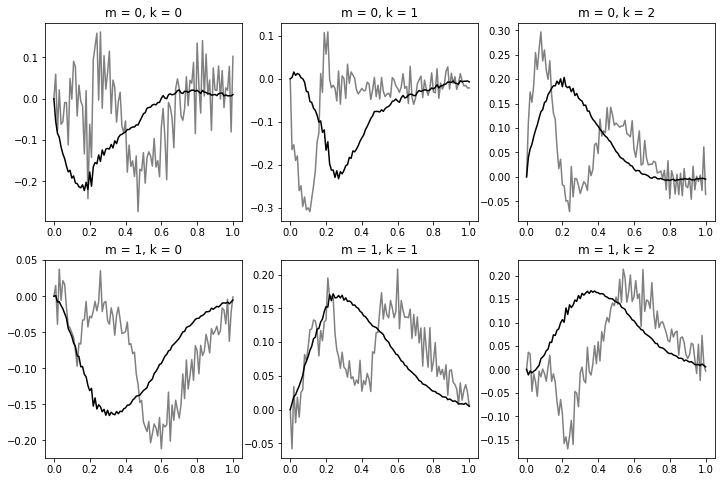

In [14]:
# Visualize filters

# Sampling time
dt = 0.01

# Visualize filters computed using both the general RC and white noise RC
# visFilters(dataMat, NTrain, NTest, dt)
visFilters(dataMat[:,:,:,::2], NTrain, NTest, dt)

To ensure classification performance is not overly influenced by the choice of training and testing set, it is valuable to perform cross-validation by compiling different training and testing sets from the full data, using each to compute training and testing accuracies, and averaging the results.

In [7]:
# Cross-validation

(2, 9226, 2, 200)